Group all imports

In [1]:
import json
from datetime import datetime
import os
from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from colorama import Fore, Style
import sys  # For printing caught exceptions
import re
from Powerfleet_APIs_Management import MongoDBConnector as DBConnector
from pathlib import Path
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import math


Enable plot UI backend

In [ ]:
%matplotlib tk

Uodate <u>PARAMETERS.json</u> with **current** date and time

In [2]:
file_path = "PARAMETERS.json" 

# Get the current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
current_time = datetime.now().strftime("%H:%M:%S")  # Format as HH:MM:SS

# Check if the file exists and is not empty
if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' does not exist.")
    exit()

# Check if the file is empty
if os.path.getsize(file_path) == 0:
    print(f"Error: The file '{file_path}' is empty.")
    exit()

# Load the current JSON data
try:
    with open(file_path, "r") as file:
        data = json.load(file)
except json.JSONDecodeError as e:
    print(f"Error: Failed to decode JSON. Details: {e}")
    exit()

# Combine the date and time
combined_datetime = current_datetime + " " + current_time

# Update the 'endDate' field in the 'snapshot_api' section
data["snapshot_api"]["endDate"] = combined_datetime

# Save the updated JSON data back to the file
try:
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)  # Use indent for readable JSON formatting
    print(f"Updated PARAMETERS.json with: {combined_datetime}.")
except Exception as e:
    print(f"Error: Failed to save the updated file. Details: {e}")


Updated PARAMETERS.json with: 2024-12-24 22:11:01.


<!-- Initialize **API** **managers** -->

In [3]:
print(Fore.YELLOW + f"MAIN CWD={os.getcwd()}")
print(f"MAIN, LISTDIR={os.listdir()}" + Style.RESET_ALL)

# Define the ApiParameterExtractor class
class ApiParameterExtractor:
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            self.parameters = json.load(file)

    def extract_parameters(self, api_type):
        # Normalize API type to lowercase
        api_type = api_type.lower()
        
        # Validate API type
        if api_type not in self.parameters:
            raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")
        
        # Return the corresponding dictionary for the given API type
        return self.parameters[api_type]


extractor = ApiParameterExtractor("PARAMETERS.json")

# Extract parameters for live_api and snapshot_api
live_api_params         = extractor.extract_parameters("live_api")
snapshot_api_params     = extractor.extract_parameters("snapshot_api")

# Pass the extracted parameters to PowerFleetAPIsManager
live_api_manager        = ApiManager(live_api_params)
snapshot_api_manager    = ApiManager(snapshot_api_params)




MAIN CWD=/home/georger/WorkDocuments/Sxoli/Ptyxiaki/Ptyxiaki-Repository/Python_Scripts/Data_Analysis
MAIN, LISTDIR=['Powerfleet_APIs_Management.py', 'segment_1.csv', 'output.csv', 'Plots', 'PARAMETERS.json', '__pycache__', 'tmp.csv', 'data_analysis.ipynb']


1. Convert **JSON** to **CSV** so that **pandas** be able to use it
2. Convert a **UNIX timestamp column** to human-readable datetime format.
2. Create **csv** for every vehicle



In [4]:
CONVERT_UNIX_TO_DATE = False

In [5]:
# === Function to Save DataFrame to CSV ===
def save_to_csv(dataframe, output_dir, file_name):
    """
    Save a DataFrame to a specified CSV file in the given directory.
    
    :param dataframe: The DataFrame to save.
    :param output_dir: The directory where the CSV file will be saved.
    :param file_name: The name of the CSV file (e.g., "file_name.csv").
    """
    if not dataframe.empty:  # Only save if the DataFrame is not empty
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        file_path = Path(output_dir) / file_name  # Construct the full file path
        dataframe.to_csv(file_path, index=False)  # Save the DataFrame to CSV
        print(f"Data saved to {file_path}")
    else:
        print(f"No data to save for {file_name}. Skipping...")

# === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
def unix_to_datetime_pandas(dataframe, column_name):
    """
    Convert a UNIX timestamp column to human-readable datetime format.
    
    :param dataframe: The DataFrame containing the column.
    :param column_name: The column name containing UNIX timestamps.
    """
    if column_name in dataframe.columns:
        try:
            dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
            print(f"Converted '{column_name}' to human-readable datetime.")
        except Exception as e:
            print(f"Error converting column '{column_name}': {e}")
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

# === Constants ===
target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Modify with your source CSV path

# === Step 1: Read Headers from the Source File ===
with open(snapshot_csv_path, mode="r") as infile:
    reader = csv.reader(infile)
    headers = next(reader)  # Extract headers from the source file

# === Step 2: Write Headers to the Target File ===
with open(target_file, mode="w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers)  # Write the headers into the target file

# === Step 3: Load Parameters from JSON File ===
with open("PARAMETERS.json", "r") as file:
    PARAMETERS = json.load(file)  # Load API parameters from the JSON file

# === Step 4: Loop to Fetch and Append Data for Each Vehicle ===
_cnt = 1  # Counter for vehicle IDs
snapshot_data = None  # Initialize snapshot_data to enter the loop

while _cnt <= 20:  # Run for up to 100 times
    # Update the vehicleId in PARAMETERS
    PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
    
    # Extract updated vehicleId and fetch snapshot data
    vehicleId = PARAMETERS["snapshot_api"]["vehicleId"]
    startDate = PARAMETERS["snapshot_api"]["startDate"]
    endDate = PARAMETERS["snapshot_api"]["endDate"]
    
    # Fetch snapshot data (Returns JSON)
    snapshot_data = snapshot_api_manager.get_snapshot_data(vehicleId, startDate, endDate)
    
    # Skip if no data is found (None or empty data)
    if not snapshot_data:
        print(f"No data found for vehicleId {vehicleId}. Skipping...")
        _cnt += 1
        continue
    
    # Parse the JSON snapshot data into a DataFrame
    try:
        # If the snapshot data is a valid JSON string, parse it
        snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
        
        # Handle JSON structure (either dict or list)
        if isinstance(snapshot_data_dict, dict):
            snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
        elif isinstance(snapshot_data_dict, list):
            snapshot_data_list = snapshot_data_dict  # Already a list of dicts
        else:
            snapshot_data_list = []
        
        # Create a DataFrame from the list of dictionaries
        snapshot_df = pd.DataFrame(snapshot_data_list)
        
        # Convert UNIX timestamps in 'dateStored' column to human-readable format
        if CONVERT_UNIX_TO_DATE != False:
            unix_to_datetime_pandas(snapshot_df, 'dateStored')
        
        # Save the DataFrame to CSV only if it's not empty
        save_to_csv(snapshot_df, "../../DataSets/API_Responses/Vehicle_Data", f"Vehicle_{_cnt}_response.csv")
    
    except json.JSONDecodeError as e:
        print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

    # Increment the vehicleId counter
    _cnt += 1

print("Process complete!")


**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_1_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_2_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_3_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_4_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_5_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_6_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_7_response.csv
**Snapshot API**
Snapshot API Request Successful!
Data saved to ../../DataSets/API_Responses/Vehi

Visualize data **dispersion**

In [6]:
PLOT_FOLDER_PATH = './Plots/'

1) Plot **unique** vehicles

../../DataSets/API_Responses/Vehicle_Data/Vehicle_2_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_3_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_19_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_11_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_16_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_6_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_18_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_17_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_9_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_20_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_14_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_1_response.csv
../../DataSets/API_Responses/Vehicle_Data/Vehicle_15_response_formatted.csv
Error reading Vehicle_15_response_formatted.csv: No columns to parse from file
../../DataSets/API_Responses/Vehicle_Data/Vehicle_12_respo

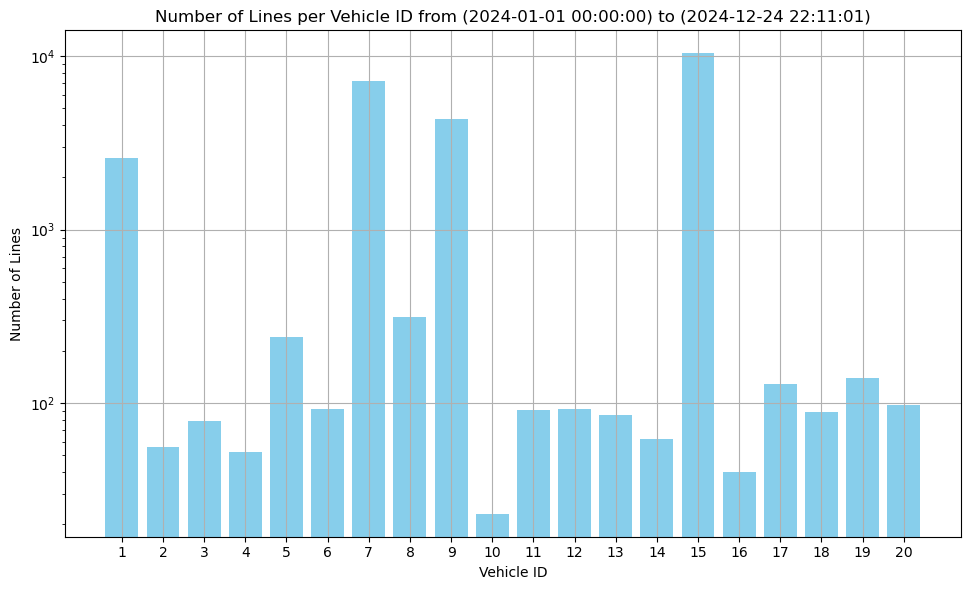

In [7]:
# Path to the folder containing the CSV files
folder_path = "../../DataSets/API_Responses/Vehicle_Data/"  # Modify with your folder path

# Initialize an empty dictionary to store vehicleId (as an integer for sorting) and its corresponding row count
vehicle_lines = {}

# Loop through the files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file and starts with "Vehicle_"
    if file_name.endswith(".csv") and file_name.startswith("Vehicle_"):
        # Extract the vehicleId from the file name (assuming the naming convention is 'Vehicle_<id>.csv')
        vehicle_id_str = file_name.split('_')[1].split('.')[0]  # Extract the part after "Vehicle_" and before ".csv"
        
        # Ensure vehicle_id is numeric; if not, skip the file
        try:
            vehicle_id = int(vehicle_id_str)  # Convert to integer for proper sorting
        except ValueError:
            print(f"Skipping file with non-numeric Vehicle ID: {file_name}")
            continue

        # Construct the full path to the file
        file_path = os.path.join(folder_path, file_name)
        print(file_path)
        
        # Read the CSV file to count the number of rows (excluding the header)
        try:
            df = pd.read_csv(file_path)
            vehicle_lines[vehicle_id] = len(df)  # Store the line count for each vehicleId
        except Exception as e:
            print(Fore.RED + f"Error reading {file_name}: {e}" + Style.RESET_ALL)

# Sort the dictionary by vehicleId (numerically in ascending order)
sorted_vehicle_lines = dict(sorted(vehicle_lines.items()))

# Convert the sorted dictionary to two lists for plotting
vehicle_ids = list(sorted_vehicle_lines.keys())
line_counts = list(sorted_vehicle_lines.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(vehicle_ids, line_counts, color='skyblue')
plt.xlabel('Vehicle ID')
plt.ylabel('Number of Lines')
plt.title(f'Number of Lines per Vehicle ID from ({PARAMETERS["snapshot_api"]["startDate"]}) to ({PARAMETERS["snapshot_api"]["endDate"]})')
plt.xticks(vehicle_ids)  # Rotate vehicle IDs if needed
plt.tight_layout()
plt.grid()

# Set a logarithmic scale for better visualization of large variations
plt.yscale("log")

# Show and save the plot
plt.savefig(os.path.join(PLOT_FOLDER_PATH, 'compare_all_vehicles.png'))
plt.show()


2. **vehicleId=15** seems to have the most lines. Plot it's **velocities**
- Create 2 columns for datetime readable for Humans and for time alone


In [8]:
# Load the CSV file into a DataFrame
VEHICLE_15_PATH = "../../DataSets/API_Responses/Vehicle_Data/Vehicle_15_response.csv"
df = pd.read_csv(VEHICLE_15_PATH)

# Convert the 'dateStored' column to datetime format
df['dateStoredHuman']       = df['dateStored'].apply(lambda x: datetime.fromtimestamp(x / 1000))
df['dateOnlyStoredHuman']   = df['dateStoredHuman'].dt.date  # Extract the date only
df['timeOnly']              = df['dateStoredHuman'].dt.time  # Extract the time only

# Sort the DataFrame by 'dateStored' in ascending order
DATA_SORTED                 = df.sort_values(by='dateStored', ascending=True)

# Extract columns of interest
lat_clmn                    = DATA_SORTED['lat']
long_clmn                   = DATA_SORTED['lng']
date_stored                 = DATA_SORTED['dateStored']

#! Drop temp columns
df = df.drop(columns=['dateStoredHuman'])


# Save the modified DataFrame back to the CSV
df.to_csv(VEHICLE_15_PATH, index=False)

# Check the first few rows of the sorted data
print(DATA_SORTED.head())

   vehicleId        lat        lng     dateStored  velocity  odometer  \
0         15  38.034933  23.748265  1716383302000       0.0       0.0   
1         15  38.034833  23.747995  1716383303000       1.0       0.0   
2         15  38.034692  23.748035  1716383339000       0.0       0.0   
3         15  38.034720  23.748038  1716383716000       8.0       0.0   
4         15  38.034725  23.748063  1716383722000       6.0       0.0   

   engineVoltage     dateStoredHuman dateOnlyStoredHuman  timeOnly  
0            0.0 2024-05-22 16:08:22          2024-05-22  16:08:22  
1            0.0 2024-05-22 16:08:23          2024-05-22  16:08:23  
2            0.0 2024-05-22 16:08:59          2024-05-22  16:08:59  
3            0.0 2024-05-22 16:15:16          2024-05-22  16:15:16  
4            0.0 2024-05-22 16:15:22          2024-05-22  16:15:22  


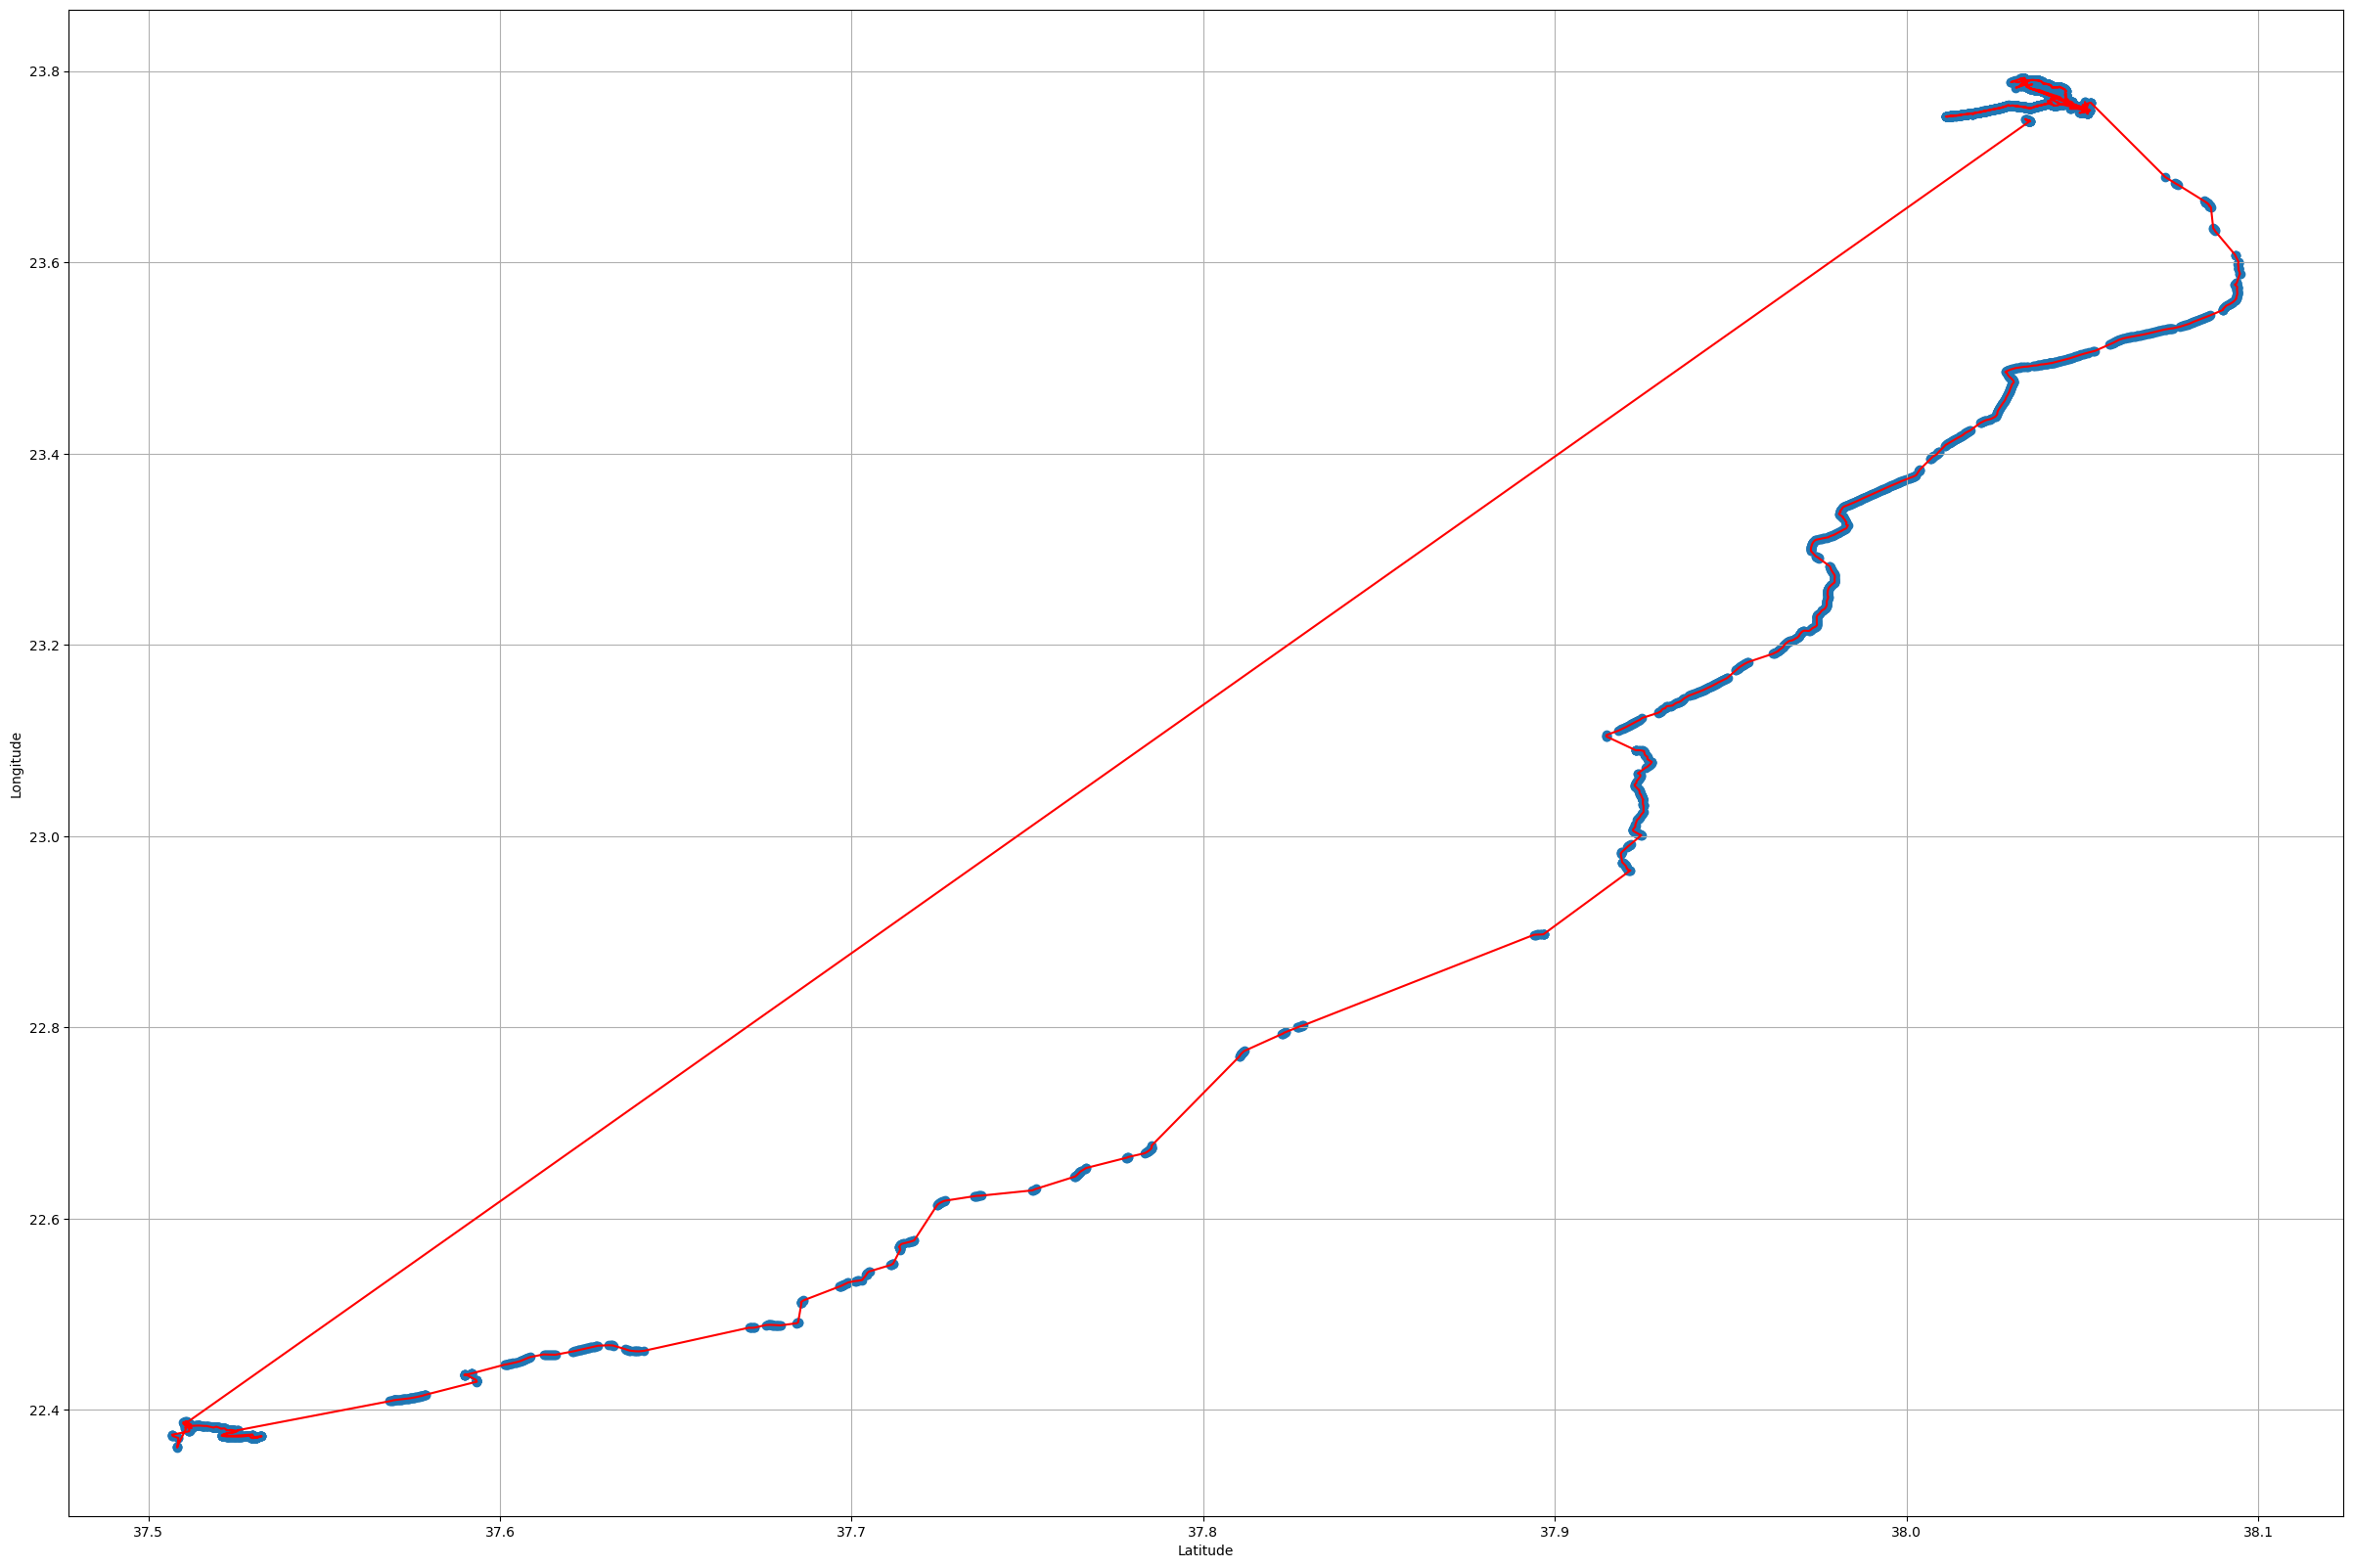

In [9]:
plt.figure(figsize=(30, 20))
# plt.title(f'from {date_stored.iloc[0].strftime("%Y-%m-%d")} to {date_stored.iloc[-1].strftime("%Y-%m-%d")}')
plt.xlabel('Latitude')
plt.ylabel('Longitude')


# Turn off offset notation
plt.gca().ticklabel_format(useOffset=False)

plt.grid()
plt.scatter(lat_clmn, long_clmn)
plt.plot(lat_clmn, long_clmn, color='r')
plt.savefig(os.path.join(PLOT_FOLDER_PATH, 'vehicle_15_coordinates'))
plt.show()

Plot all trips of current vehicle

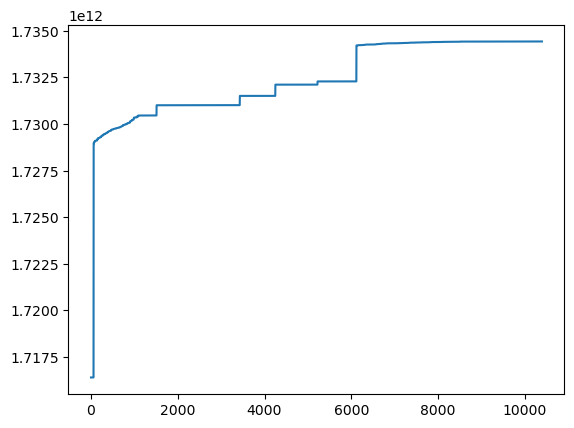

In [10]:
plt.plot(range(len(df['dateStored'])), df['dateStored'])
plt.savefig(os.path.join(PLOT_FOLDER_PATH, 'vehicle_15_all_trips'))
plt.show()


Plot velocity

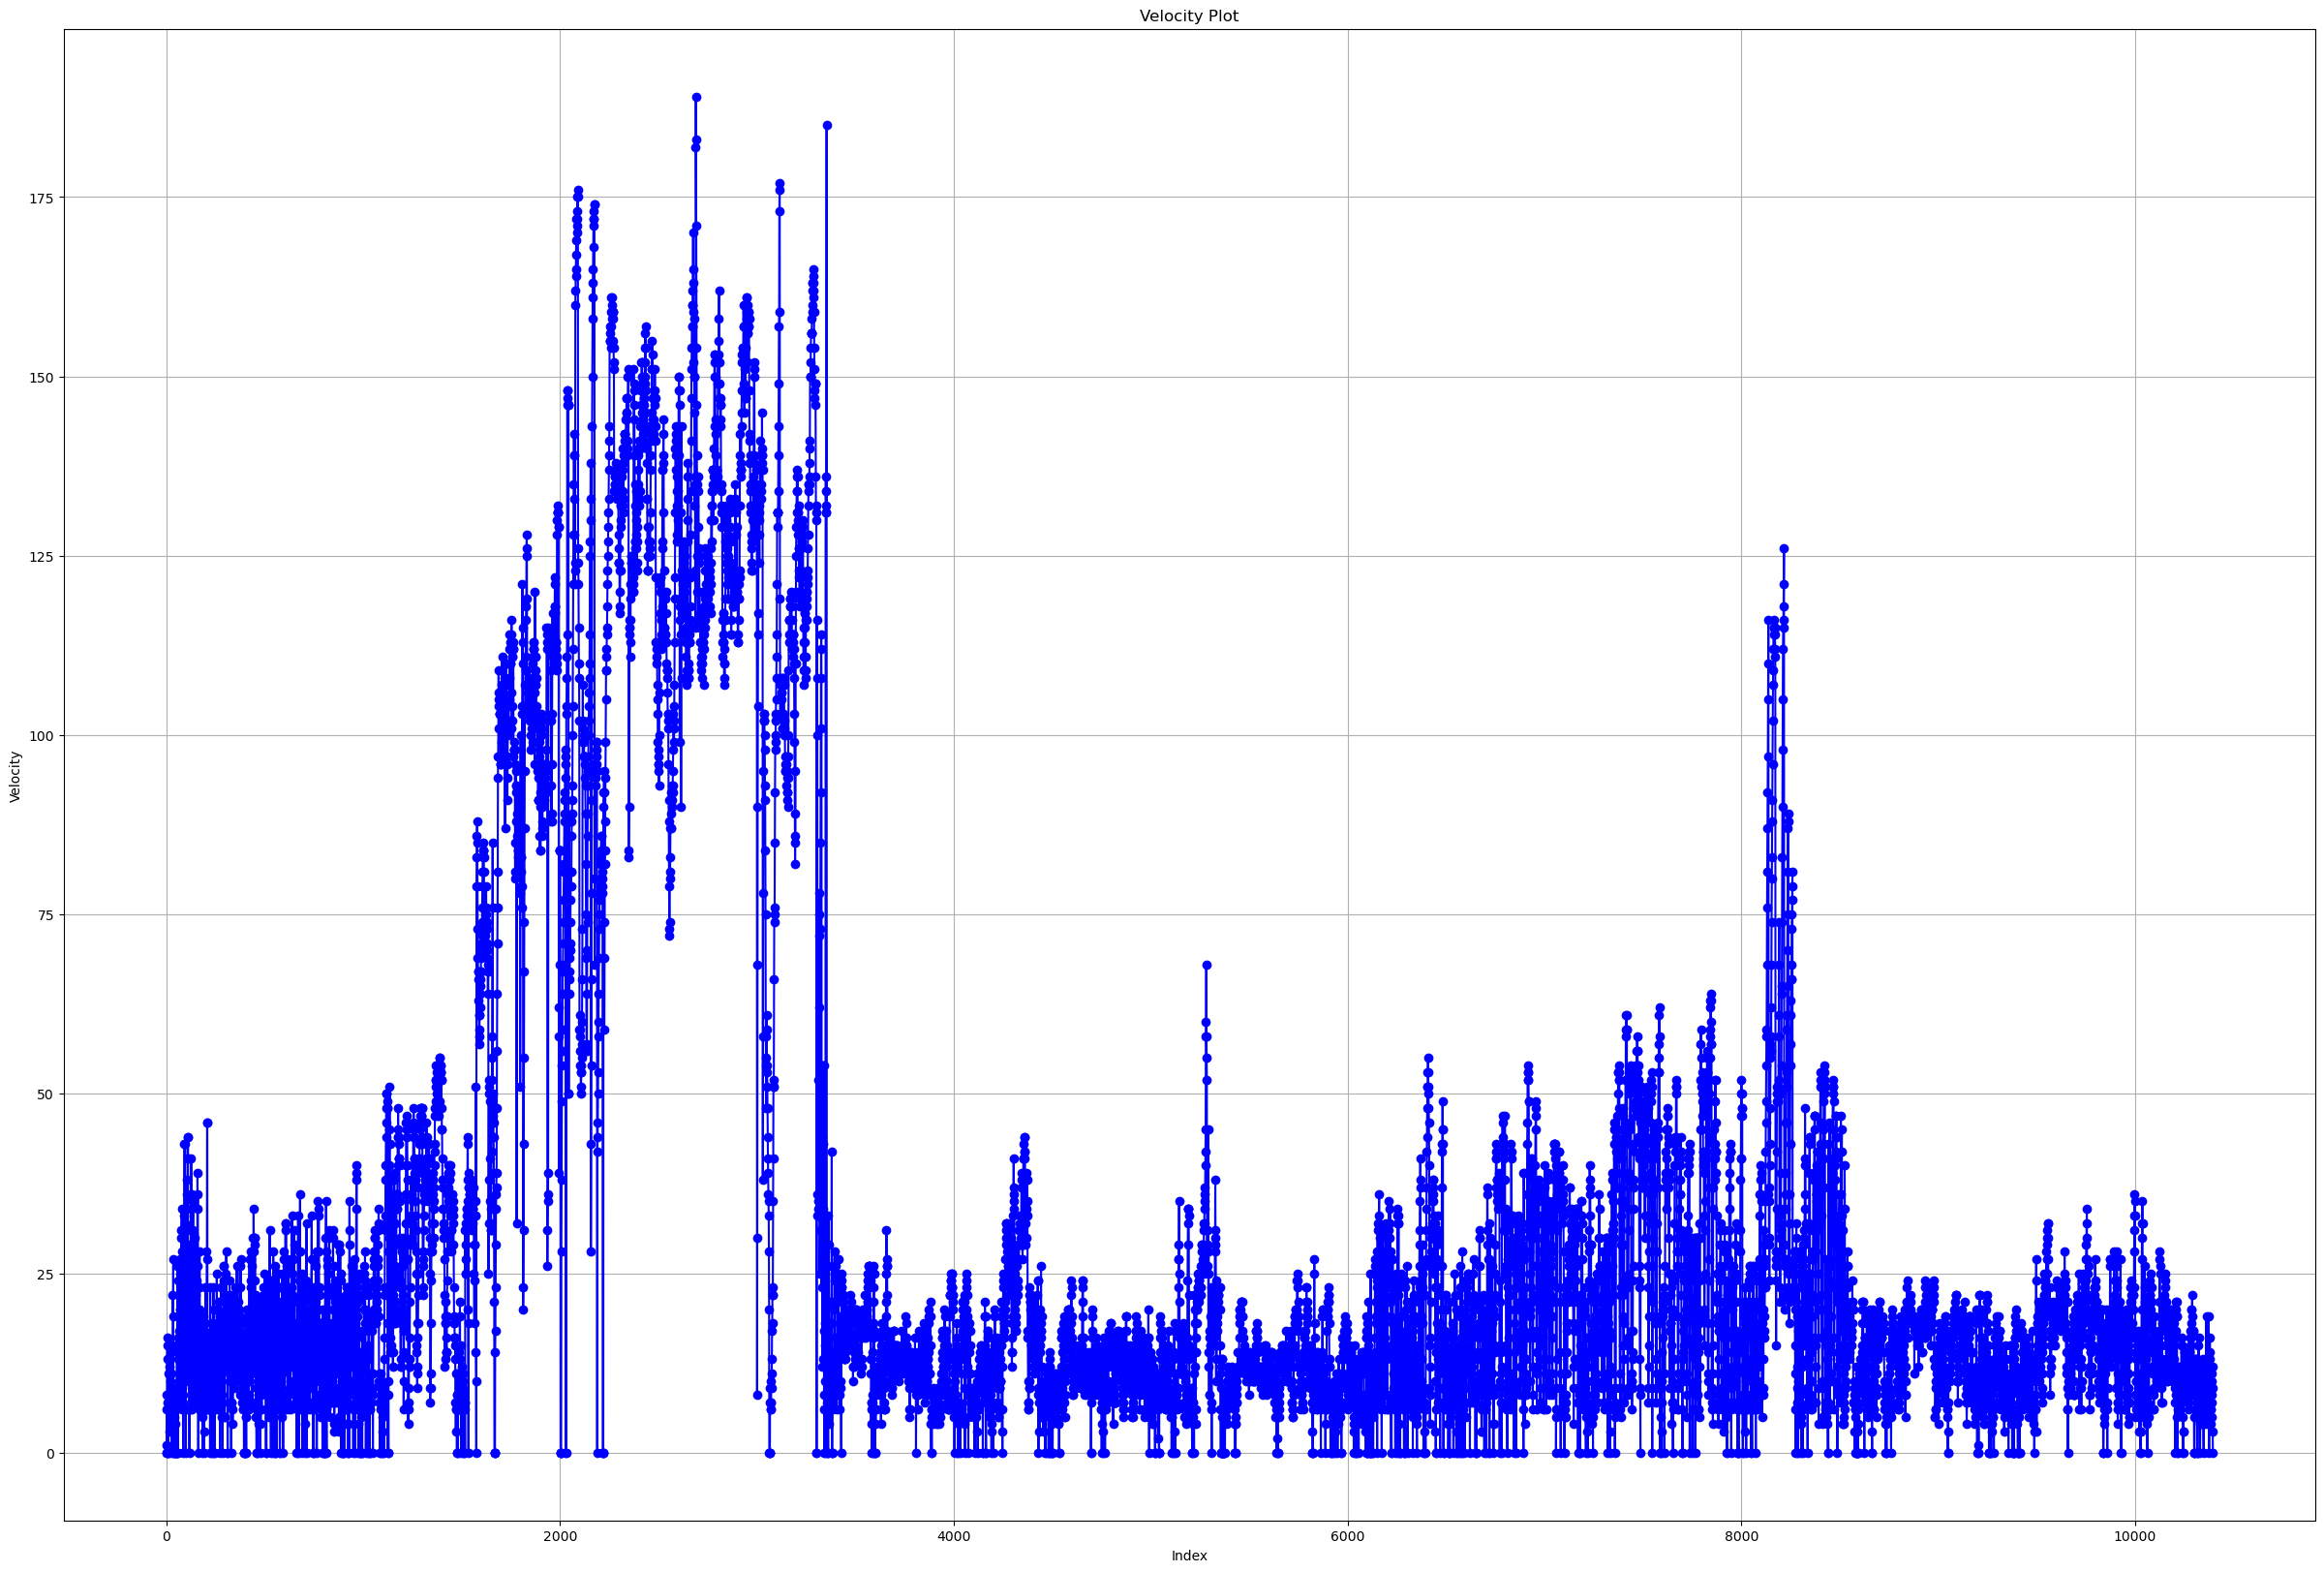

In [11]:
plt.figure(figsize=(30, 20))
plt.plot(df['velocity'], marker='o', linestyle='-', color='b')
plt.title('Velocity Plot')
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.grid(True)
plt.savefig(os.path.join(PLOT_FOLDER_PATH, 'velocity_dispersion.png'))
plt.show()


- Calculate which the **30 degrees turns** on coordinatess
- Plot the **30 degrees turns** vs velocities **before and after** making the turn

| Decimal Places | Latitude Precision (meters) | Longitude Precision (meters at Equator) |
|----------------|-----------------------------|-----------------------------------------|
| 1              | ~11,132 m                   | ~11,132 m                               |
| 2              | ~1,113 m                    | ~1,113 m                                |
| 3              | ~111.3 m                    | ~111.3 m                                |
| 4              | ~11.13 m                    | ~11.13 m                                |
| 5              | ~1.113 m                    | ~1.113 m                                |
| 6              | ~0.1113 m                   | ~0.1113 m                               |
| 7              | ~0.01113 m                  | ~0.01113 m                              |
| 8              | ~0.001113 m                 | ~0.001113 m                             |

In [12]:
def process_coordinates(DATA_SORTED):
    # Load the dataset into a GeoDataFrame
    gdf = gpd.GeoDataFrame(DATA_SORTED, geometry=gpd.points_from_xy(DATA_SORTED['lng'], DATA_SORTED['lat']))

    # Function to calculate precision correspondences
    def calculate_precision_distances():
        precision_list = []
        for decimals in range(1, 9):  # For 1 to 8 decimals
            latitude_precision = 111_320 / (10**decimals)  # Latitude: meters
            longitude_precision = latitude_precision  # Assuming equator (lat = 0)
            precision_list.append((decimals, latitude_precision, longitude_precision))
        return precision_list

    # Calculate precision distances
    precisions = calculate_precision_distances()

    # Create a DataFrame for output
    precision_df = pd.DataFrame(precisions, columns=['Decimal Places', 'Latitude Precision (m)', 'Longitude Precision (m)'])
    # print(precision_df)

    # Function to calculate the bearing between two points
    def calculate_bearing(lat1, lon1, lat2, lon2):
        """
        Calculate the bearing between two points.
        Returns the bearing in degrees.
        """
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)

        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        bearing_degrees = (math.degrees(bearing) + 360) % 360  # Normalize to 0-360
        return bearing_degrees

    # Function to get orientation from bearing
    def get_orientation(bearing):
        """
        Convert a bearing in degrees to a cardinal direction.
        """
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        idx = round(bearing / 45) % 8  # Divide by 45 degrees for 8 cardinal directions
        return directions[idx]

    # Function to get the latest and next coordinate
    def get_latest_and_next_coordinates(gdf):
        latest_coordinate = gdf.iloc[-1]  # The last entry is the latest coordinate
        # print("Latest coordinate:", latest_coordinate)

        # Get next coordinates and calculate bearings
        next_coordinates = []
        for idx in range(len(gdf) - 1):
            current_row = gdf.iloc[idx]
            next_row = gdf.iloc[idx + 1]
            bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
            orientation = get_orientation(bearing)
            next_coordinates.append((current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'], bearing, orientation))
        
        return latest_coordinate, next_coordinates

    # Get the latest and next coordinates
    latest_coordinate, next_coordinates = get_latest_and_next_coordinates(gdf)

    # Print the results
    print("\nLatest Coordinate:")
    print(latest_coordinate[['lat', 'lng']])

    print("\nNext Coordinates with Orientation:")
    for coord in next_coordinates:
        print(f"Current: ({coord[0]}, {coord[1]}) -> Next: ({coord[2]}, {coord[3]}) | Bearing: {coord[4]:.2f}° | Orientation: {coord[5]}")

    return latest_coordinate, next_coordinates


# Assuming 'DATA_SORTED' is already defined as a DataFrame with columns 'lat' and 'lng'
latest_coordinate, next_coordinates = process_coordinates(DATA_SORTED)



Latest Coordinate:
lat    38.050772
lng    23.761143
Name: 10394, dtype: object

Next Coordinates with Orientation:
Current: (38.0349333, 23.7482649) -> Next: (38.0348333, 23.747995) | Bearing: 244.81° | Orientation: Southwest
Current: (38.0348333, 23.747995) -> Next: (38.0346916, 23.7480349) | Bearing: 167.50° | Orientation: South
Current: (38.0346916, 23.7480349) -> Next: (38.03472, 23.7480383) | Bearing: 5.39° | Orientation: North
Current: (38.03472, 23.7480383) -> Next: (38.034725, 23.7480633) | Bearing: 75.75° | Orientation: East
Current: (38.034725, 23.7480633) -> Next: (38.0348666, 23.7479199) | Bearing: 321.42° | Orientation: Northwest
Current: (38.0348666, 23.7479199) -> Next: (38.0349916, 23.7477399) | Bearing: 311.40° | Orientation: Northwest
Current: (38.0349916, 23.7477399) -> Next: (38.0351233, 23.7475533) | Bearing: 311.86° | Orientation: Northwest
Current: (38.0351233, 23.7475533) -> Next: (38.0351266, 23.7475233) | Bearing: 277.95° | Orientation: West
Current: (38.035

Add <u>**orientation column for the 30 degrees turns</u>** to corresponding coordinates

In [13]:
def add_orientation_column(DATA_SORTED):
    # Function to calculate the bearing between two points
    def calculate_bearing(lat1, lon1, lat2, lon2):
        """
        Calculate the bearing between two points.
        Returns the bearing in degrees.
        """
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)

        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        bearing_degrees = (math.degrees(bearing) + 360) % 360  # Normalize to 0-360
        return bearing_degrees

    # Function to get orientation from bearing
    def get_orientation(bearing):
        """
        Convert a bearing in degrees to a cardinal direction.
        """
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        idx = round(bearing / 45) % 8  # Divide by 45 degrees for 8 cardinal directions
        return directions[idx]

    # Add a new column "orientation"
    orientations = []

    # Loop through the DataFrame to calculate the bearing and orientation for each pair of consecutive coordinates
    for idx in range(len(DATA_SORTED) - 1):
        current_row = DATA_SORTED.iloc[idx]
        next_row = DATA_SORTED.iloc[idx + 1]
        
        # Calculate the bearing
        bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
        
        # Get the orientation from the bearing
        orientation = get_orientation(bearing)
        
        # Append the orientation to the list
        orientations.append(orientation)

    # For the last row, we can either leave the orientation empty or set it as "" since it has no "next" coordinate
    orientations.append("")

    # Add the "orientation" column to the DataFrame
    DATA_SORTED['orientation'] = orientations

    # Return the updated DataFrame
    return DATA_SORTED

# Assuming 'DATA_SORTED' is already defined as a DataFrame with columns 'lat' and 'lng'
DATA_SORTED = add_orientation_column(DATA_SORTED)

# Write the updated DataFrame to a CSV file
DATA_SORTED.to_csv(VEHICLE_15_PATH, index=False)

# Check the updated DataFrame
print(Fore.YELLOW + F"Updated DataFrame written to {VEHICLE_15_PATH}." + Style.RESET_ALL)


Updated DataFrame written to ../../DataSets/API_Responses/Vehicle_Data/Vehicle_15_response.csv.


Plot the months with the most data

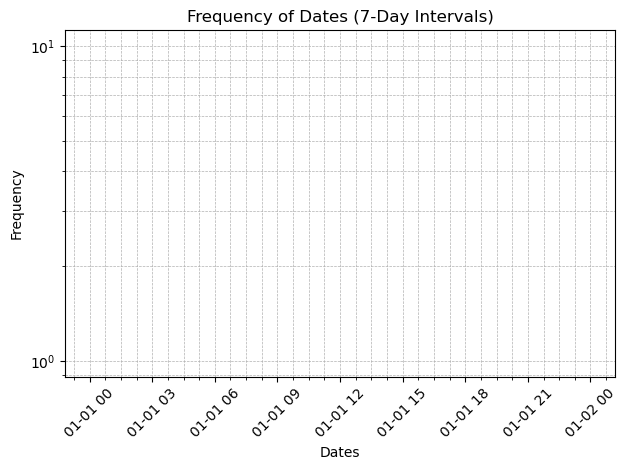

In [14]:
# Assuming df is your DataFrame
df['dateOnlyStoredHuman'] = pd.to_datetime(df['dateOnlyStoredHuman'])

# Add a column for frequency (each entry is treated as one occurrence)
df['frequency'] = 1

# Group by 7-day intervals
df['frequency'] = df.groupby(
    pd.Grouper(key='dateOnlyStoredHuman', freq='7D', sort=True)
)['frequency'].sum()

# Reset index for plotting
df['frequency'].reset_index()

# Plotting
plt.bar(df['dateOnlyStoredHuman'], df['frequency'], width=5, align='center')  # Adjust width for better spacing
plt.title('Frequency of Dates (7-Day Intervals)')
plt.xlabel('Dates')
plt.ylabel('Frequency')
plt.yscale('log')  # Use a log scale if needed for better visualization
plt.minorticks_on()
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig(os.path.join(PLOT_FOLDER_PATH, 'frequency_chart.png'))  # Save the plot as an image
plt.show()


Plot **velocities** of <u>1 day<u/> 

In [31]:
def generate_all_days(file_path):
    """
    Generates a DataFrame containing all unique days in ISO format.

    Args: 
        file_path (str): The file's path.

    Returns:
        tuple: 
            - pd.DataFrame: Original data with date columns added.
            - pd.DataFrame: A DataFrame where each row contains a unique day in ISO format.
    """
    try:
        # Load the file into a DataFrame
        data = pd.read_csv(file_path)

        # Verify that the required columns exist
        if 'timeOnly' not in data.columns or 'dateStored' not in data.columns:
            raise KeyError("The file must contain 'timeOnly' and 'dateStored' columns.")

        # Convert the 'dateStored' column to datetime for filtering
        data['dateStoredHuman'] = pd.to_datetime(data['dateStored'], unit='ms')
        
        # Extract the date-only part in ISO format
        data['dateOnly'] = data['dateStoredHuman'].dt.date

        # Get unique dates and sort them
        unique_days = sorted(data['dateOnly'].unique())

        # Create a new DataFrame for the unique days
        days_df = pd.DataFrame(unique_days, columns=["Day"])
        days_df['Day'] = days_df['Day'].astype(str)  # Convert to ISO string format

        return data, days_df

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return pd.DataFrame(), pd.DataFrame(columns=["Day"])
    except KeyError as e:
        print(f"Error: Missing expected column in the file. {e}")
        return pd.DataFrame(), pd.DataFrame(columns=["Day"])
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return pd.DataFrame(), pd.DataFrame(columns=["Day"])


# Generate all days
data, df_all_days = generate_all_days(VEHICLE_15_PATH)

if not df_all_days.empty:
    single_day = df_all_days['Day'][0]  # Select the first day
    single_day_data = data[data['dateOnly'] == pd.to_datetime(single_day).date()]  # Filter data for the single day

    if not single_day_data.empty:
        # Extract velocity and time
        velocities = single_day_data['velocity'] if 'velocity' in single_day_data.columns else [0] * len(single_day_data)
        time_labels = single_day_data['timeOnly']
        orientations = single_day_data['orientation'] if 'orientation' in single_day_data.columns else [''] * len(single_day_data)
        
        # Plot the velocities for the single day
        plt.figure(figsize=(40, 30))
        plt.plot(time_labels, velocities, marker='o', linestyle='-', color='b')

        # Label the points with orientations
        for i, txt in enumerate(orientations):
            plt.text(time_labels[i], velocities[i], f'{txt}', ha='left', va='bottom', fontsize=9)

        plt.title(f"Velocities on {single_day}")
        plt.xlabel('Time (HH:MM:SS)')
        plt.ylabel('Velocity')
        plt.xticks(rotation=45)
        plt.grid(True)

        # Save the plot
        plot_filename = os.path.join(PLOT_FOLDER_PATH, f'{single_day}_velocities.png')
        plt.savefig(plot_filename)
        print(f"Plot saved as {plot_filename}")

        # Show the plot
        plt.show()
    else:
        print(f"No data available for the selected day: {single_day}")
else:
    print("No days available in the data.")


Plot saved as ./Plots/2024-05-22_velocities.png


Plot <u>velocities, orientations</u> **on** <u>coordinates</u>>

In [33]:
plt.figure(figsize=(20, 10))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
# Turn off offset notation
plt.gca().ticklabel_format(useOffset=False)
plt.grid()
scatter = plt.scatter(lat_clmn, long_clmn, c=df['velocity'], cmap='viridis', s=100, edgecolors='k')
#* Add color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Velocities')
plt.savefig(os.path.join(PLOT_FOLDER_PATH, 'coordinates_velocities.png'))
plt.show()

KeyError: 'velocity'

According to Powerfleet parking is considered <u>5 minutes</u> on the same coordinates

In [32]:
print(df.columns)

# Convert 'timeOnly' column to timedelta
df['timeOnly'] = pd.to_timedelta(df['timeOnly'])

# Calculate the time differences
df['time_diff'] = df['timeOnly'].diff()

# Handle midnight crossings (if necessary)
df['time_diff'] = df['time_diff'].apply(lambda x: x if pd.isnull(x) or x >= pd.Timedelta(0) else x + pd.Timedelta(days=1))

#* Check if lat and lon are the same for rows where time_diff >= 5 minutes
df['same_location'] = df.apply(
    lambda row: (
        row['time_diff'] >= pd.Timedelta(minutes=5) and 
        df.loc[row.name - 1, 'lat'] == row['lat'] and 
        df.loc[row.name - 1, 'lng'] == row['lng']
    ) if row.name > 0 else False,
    axis=1
)

# Print the DataFrame
print(df)


Index(['timeOnly', 'time_diff'], dtype='object')


KeyError: 'lat'